# Exporting and plotting fitbit data

In [1]:
# This is a python file you need to have in the same directory as your code so you can import it
import gather_keys_oauth2 as Oauth2
import fitbit
import pandas as pd
import datetime
import os
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load your credentials
load_dotenv(find_dotenv())

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

In [3]:
server=Oauth2.OAuth2Server(CLIENT_ID,
                           CLIENT_SECRET)
server.browser_authorize()
ACCESS_TOKEN=str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN=str(server.fitbit.client.session.token['refresh_token'])
auth2_client=fitbit.Fitbit(CLIENT_ID,
                           CLIENT_SECRET,
                           oauth2=True,
                           access_token=ACCESS_TOKEN,
                           refresh_token=REFRESH_TOKEN)

[11/Oct/2021:10:12:07] ENGINE Listening for SIGTERM.
[11/Oct/2021:10:12:07] ENGINE Listening for SIGHUP.
[11/Oct/2021:10:12:07] ENGINE Listening for SIGUSR1.
[11/Oct/2021:10:12:07] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[11/Oct/2021:10:12:07] ENGINE Started monitor thread 'Autoreloader'.
[11/Oct/2021:10:12:07] ENGINE Serving on http://127.0.0.1:8080
[11/Oct/2021:10:12:07] ENGINE Bus STARTED


127.0.0.1 - - [11/Oct/2021:10:12:08] "GET /?code=e2eead0aae6fa9533ad75a2a18f1350eaf4149ae&state=qMPByqrnaPeamoqsWDvFs5rSE0dQ2V HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Safari/605.1.15"


[11/Oct/2021:10:12:09] ENGINE Bus STOPPING
[11/Oct/2021:10:12:09] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[11/Oct/2021:10:12:09] ENGINE Stopped thread 'Autoreloader'.
[11/Oct/2021:10:12:09] ENGINE Bus STOPPED
[11/Oct/2021:10:12:09] ENGINE Bus EXITING
[11/Oct/2021:10:12:09] ENGINE Bus EXITED
[11/Oct/2021:10:12:09] ENGINE Waiting for child threads to terminate...


## Export data from API
#### Options:
__Activity__
- activities/calories
- activities/caloriesBMR
- activities/steps
- activities/distance
- activities/floors
- activities/elevation
- activities/minutesSedentary
- activities/minutesLightlyActive
- activities/minutesFairlyActive
- activities/minutesVeryActive
- activities/activityCalories </br>

__Tracker Activity__
- activities/tracker/calories
- activities/tracker/steps
- activities/tracker/distance
- activities/tracker/floors
- activities/tracker/elevation
- activities/tracker/minutesSedentary
- activities/tracker/minutesLightlyActive
- activities/tracker/minutesFairlyActive
- activities/tracker/minutesVeryActive
- activities/tracker/activityCalories

In [4]:
# This is the date of data that I want.
# You will need to modify for the date you want
# oneDate = pd.datetime(year = 2021, month = 1, day = 21)
oneDate = datetime.datetime.now().date() - datetime.timedelta(6)
oneDayData = auth2_client.intraday_time_series('activities/heart', oneDate, detail_level='1sec')

In [5]:
oneDate

datetime.date(2021, 10, 5)

In [6]:
df = pd.DataFrame(oneDayData["activities-heart-intraday"]["dataset"])
df = df.assign(time = lambda x: pd.to_datetime(str(f"{oneDate} ") + df["time"]))

display(df.head()), df.shape

,time,value
0,2021-10-05 00:00:06,59
1,2021-10-05 00:00:11,60
2,2021-10-05 00:00:16,61
3,2021-10-05 00:00:21,59
4,2021-10-05 00:00:26,57


(None, (11015, 2))

## Today's heart rate data

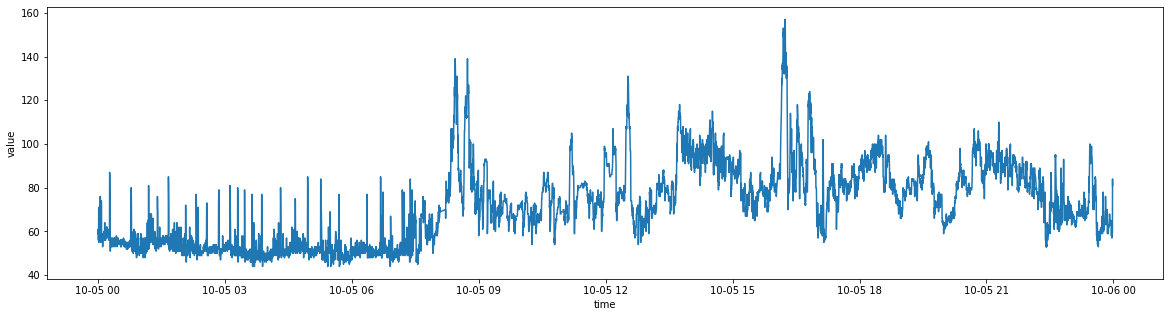

In [7]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=df,
                 x="time",
                 y="value"
                 )

In [8]:
oneDayData = auth2_client.intraday_time_series('activities/steps', oneDate, detail_level='1min')

In [9]:
df = pd.DataFrame(oneDayData["activities-steps-intraday"]["dataset"])
df = df.assign(time = lambda x: pd.to_datetime(str(f"{oneDate} ") + df["time"]))

display(df.head()), df.shape

,time,value
0,2021-10-05 00:00:00,0
1,2021-10-05 00:01:00,0
2,2021-10-05 00:02:00,0
3,2021-10-05 00:03:00,0
4,2021-10-05 00:04:00,0


(None, (1440, 2))

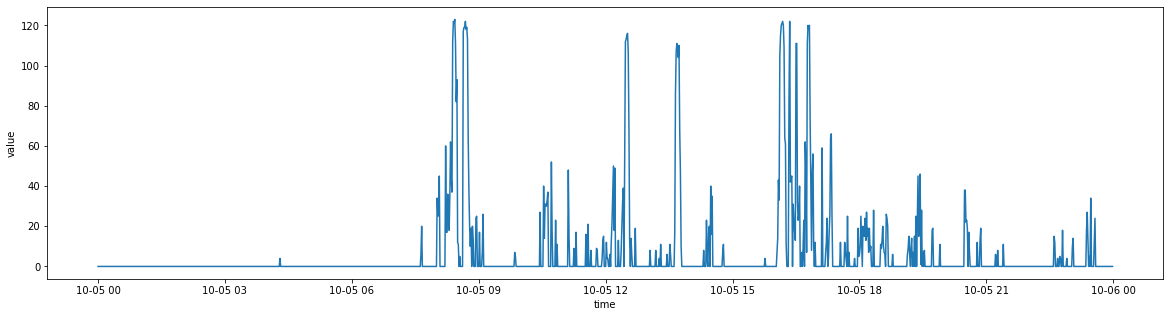

In [10]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=df,
                 x="time",
                 y="value"
                 )

In [11]:
oneDayData = auth2_client.intraday_time_series('activities/distance', oneDate, detail_level='1min')

In [12]:
df = pd.DataFrame(oneDayData["activities-distance-intraday"]["dataset"])
df = (df.assign(time = lambda x: pd.to_datetime(str(f"{oneDate} ") + df["time"]))
      .assign(value = lambda x: x["value"].cumsum())
     )

display(df.head()), df.shape

,time,value
0,2021-10-05 00:00:00,0.0
1,2021-10-05 00:01:00,0.0
2,2021-10-05 00:02:00,0.0
3,2021-10-05 00:03:00,0.0
4,2021-10-05 00:04:00,0.0


(None, (1440, 2))

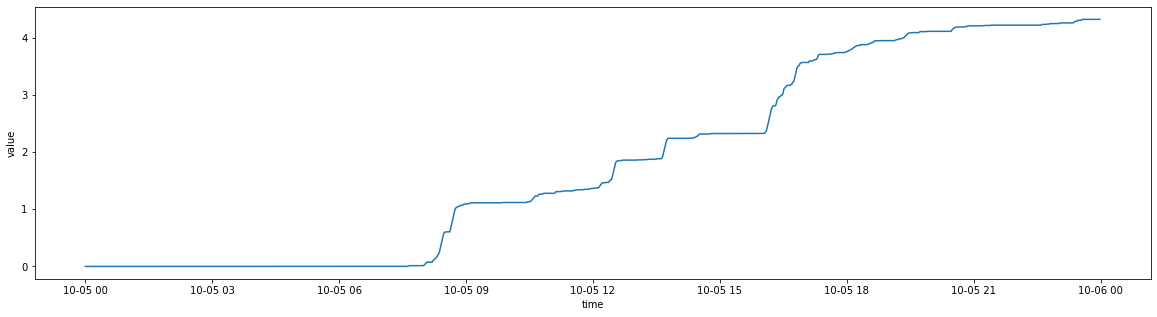

In [13]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=df,
                 x="time",
                 y="value"
                 )

In [14]:
oneDayData = auth2_client.sleep(oneDate)

In [15]:
df = pd.DataFrame(oneDayData["sleep"][0]["minuteData"])
df = (df.assign(dateTime = lambda x: pd.to_datetime(str(f"{oneDate} ") + df["dateTime"]))
#       .assign(value = lambda x: x["value"].cumsum())
     )

display(df.head()), df.shape

,dateTime,value
0,2021-10-05 23:25:30,3
1,2021-10-05 23:26:30,3
2,2021-10-05 23:27:30,2
3,2021-10-05 23:28:30,3
4,2021-10-05 23:29:30,3


(None, (479, 2))

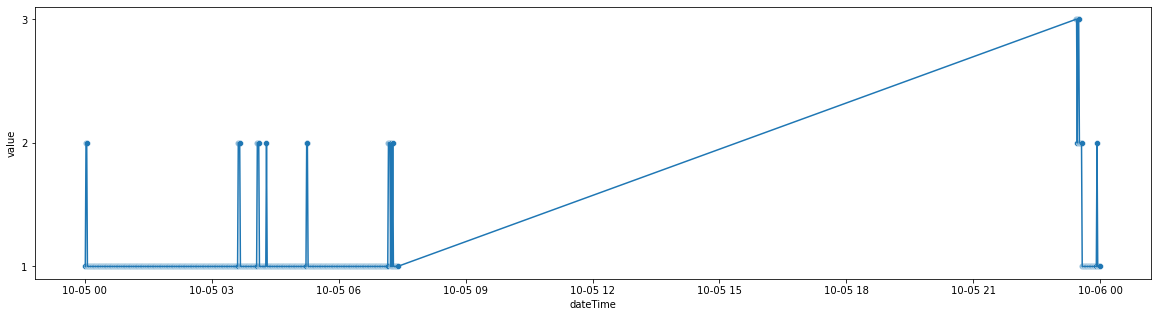

In [16]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=df,
                 x="dateTime",
                 y="value"
                 )
_ = sns.scatterplot(data=df,
                 x="dateTime",
                 y="value"
                 )